In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import sys
sys.path.append('..')

import logging
from src.utils import setup_logging
setup_logging(console=True, file=True, debug=True, file_basename="k_sweep_BIG")
logger = logging.getLogger(__name__)

import pandas as pd
from data.tempdata import TempData
import matplotlib.pyplot as plt

from src.plot import plot_predictive
from src.informed_np import InformedNeuralProcess
from tqdm import tqdm
# from src.loss import ELBOLoss
from src.loss import ELBOLoss
from src.train import train  

[INFO]: Logging setup completed at 11-08-2024-105029        (utils.py:62 [10:50:29])
/workspace/miniconda3/envs/pt2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def eval(model, data, use_knowledge=True, num_context=None):
    model.training = False
    with torch.no_grad():
        test_loss = 0
        n_test_batches = 128
        test_batch_size = 96
        for _ in range(n_test_batches):
            batch = data.generate_batch(batch_size=test_batch_size,
                                    device=DEVICE,
                                    return_knowledge=use_knowledge,
                                    split='test',
                                    num_context=num_context)

            p_y_pred, q_z_context, q_z_target = model(batch.x_context,
                                                  batch.y_context,
                                                  batch.x_target,
                                                  batch.y_target,
                                                  batch.knowledge)
            test_loss_dict = loss_function(p_y_pred, q_z_context, None, batch.y_target)
            test_loss += test_loss_dict["loss"].item() / n_test_batches
        # val_losses.append(val_loss)
        
    model.training = True
    print(f"Test Loss: {test_loss}, use_knowledge={use_knowledge}, num_context={num_context}")
    return test_loss

def k_and_nok_eval(model, data):
    k_test_losses = []
    nok_test_losses = []

    for num_context in range(1, 11):
        k_test_losses.append(eval(model, data, use_knowledge=True, num_context=num_context))
        nok_test_losses.append(eval(model, data, use_knowledge=False, num_context=num_context))

    return k_test_losses, nok_test_losses




In [3]:

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logging.info(f'Using DEVICE: {DEVICE}')



x_dim = 1
y_dim = 1
determ_dim = 128  # Dimension of representation of context points
latent_dim = 128  # Dimension of sampled latent variable
hidden_dim = 128  # Dimension of hidden layers in encoder and decoder

args = dict(
            x_dim=x_dim,
            y_dim=y_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            determ_dim=determ_dim,
            knowledge_dim=128,
            mlps_activation=nn.GELU(),
            x_proj_dim=1,
            n_h_layers_x_proj=0,
            n_h_layers_decoder=4,
            n_h_layers_latent_xy_encoder=3,
            n_h_layers_film_latent_encoder=3,
            path='latent',
            train_num_z_samples=4,
            test_num_z_samples=32,
            use_bias=True,
            use_context_in_target=True, # TODO investigate
            use_latent_self_attn=True,
            # use_determ_self_attn=True,
            # use_determ_cross_attn=True,
            # use_knowledge=USE_KNOWLEDGE,
            # knowledge_dropout=0.3,
            roberta_return_cls=True,
            tune_llm_layer_norms=True,
            freeze_llm=True,
            knowledge_projection_n_h_layers=0,
            knowledge_aggregation_method='FiLM+MLP',
            device='cuda',
            beta=1.0
        )
assert "use_knowledge" not in args
assert "knowledge_dropout" not in args

data_path = '../data/data_with_desc.csv'
data_df = pd.read_csv(data_path, header=None)


AVG_LOSS_PRINT_INTERVAL = 250
PLOT_SAMPLE_INTERVAL = 1000
MAX_ITERS = 10000

LEARNING_RATE = 1e-3
loss_function = ELBOLoss(beta=1, reduction='mean')
random_states = [85, 98, 87]

MAX_NUM_CONTEXT = 10



[INFO]: Using DEVICE: cuda:0        (3197260226.py:2 [19:12:29])


[INFO]: USE_KNOWLEDGE: False        (4055599156.py:3 [22:10:07])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [22:10:08])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [22:10:08])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [22:10:08])
[INFO]: Saving new best val loss model at iter 1        (train.py:122 [22:10:09])


iter 1: Val. Loss (NLL): 24921.165328979492


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-85_iter1.pt'        (train.py:129 [22:10:14])
[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/np-kdropsweep-rs-85_iter250.pt        (train.py:134 [22:10:14])


iter 250: Val. Loss (NLL): 966.2086234092712


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-85_iter250.pt'        (train.py:129 [22:10:20])
[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/np-kdropsweep-rs-85_iter500.pt        (train.py:134 [22:10:20])


iter 500: Val. Loss (NLL): 604.29780626297
iter 750: Val. Loss (NLL): 653.8250370025635
iter 1000: Val. Loss (NLL): 682.5128290653229
iter 1250: Val. Loss (NLL): 617.8251218795776
iter 1500: Val. Loss (NLL): 679.6982204914093
iter 1750: Val. Loss (NLL): 606.2621083259583


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-85_iter500.pt'        (train.py:129 [22:10:52])
[INFO]: Saving new best val loss model at iter 2000 to path ../exp/sweep/np-kdropsweep-rs-85_iter2000.pt        (train.py:134 [22:10:52])


iter 2000: Val. Loss (NLL): 598.7668025493622


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-85_iter2000.pt'        (train.py:129 [22:10:58])
[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/np-kdropsweep-rs-85_iter2250.pt        (train.py:134 [22:10:58])


iter 2250: Val. Loss (NLL): 580.4150178432465
iter 2500: Val. Loss (NLL): 612.5463402271271
iter 2750: Val. Loss (NLL): 661.8228616714478
iter 3000: Val. Loss (NLL): 766.802579164505
iter 3250: Val. Loss (NLL): 633.8717684745789
iter 3500: Val. Loss (NLL): 685.6634168624878
iter 3750: Val. Loss (NLL): 708.0575556755066
iter 4000: Val. Loss (NLL): 663.1761882305145
iter 4250: Val. Loss (NLL): 736.1205441951752
iter 4500: Val. Loss (NLL): 771.3647785186768


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [22:11:52])


iter 4750: Val. Loss (NLL): 751.4832782745361


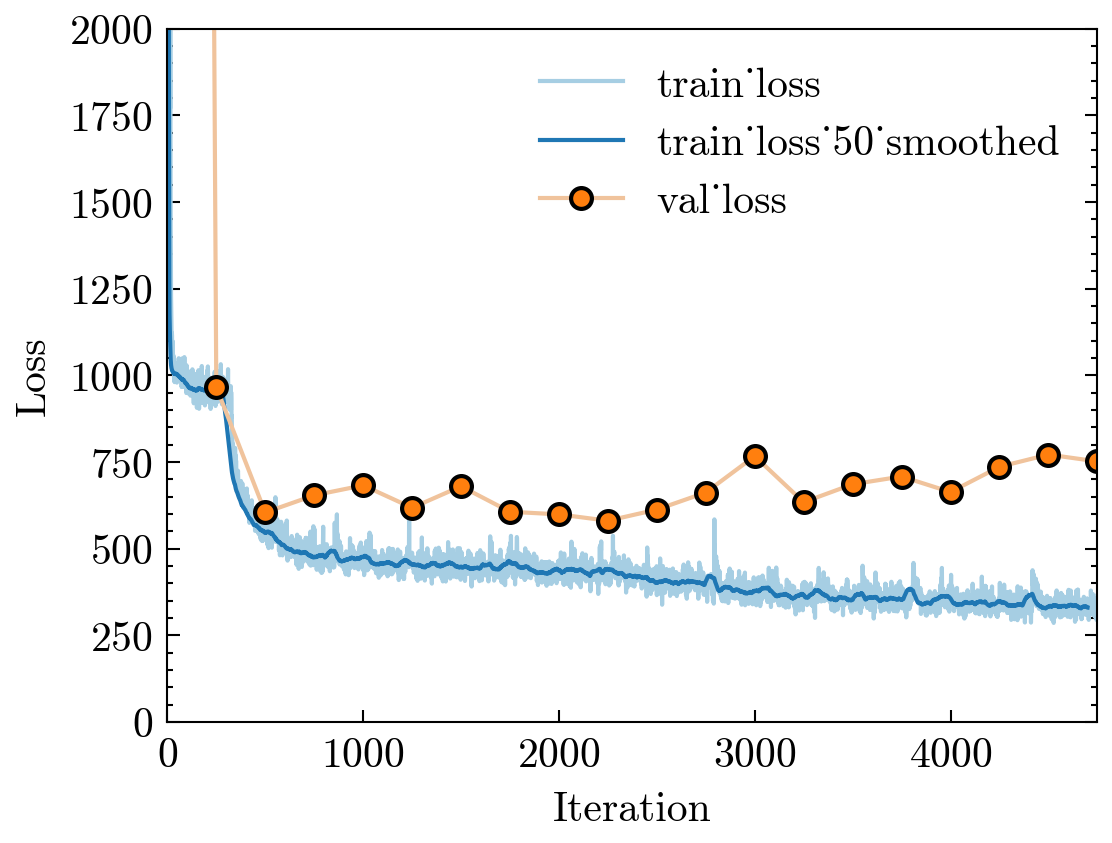

Test Loss: 971.5142154693604, use_knowledge=True, num_context=1
Test Loss: 973.3297877311707, use_knowledge=False, num_context=1
Test Loss: 723.9629561901093, use_knowledge=True, num_context=2
Test Loss: 738.5048406124115, use_knowledge=False, num_context=2
Test Loss: 667.7470300197601, use_knowledge=True, num_context=3
Test Loss: 648.5571930408478, use_knowledge=False, num_context=3
Test Loss: 616.3927805423737, use_knowledge=True, num_context=4
Test Loss: 591.749890089035, use_knowledge=False, num_context=4
Test Loss: 572.5682611465454, use_knowledge=True, num_context=5
Test Loss: 584.9485664367676, use_knowledge=False, num_context=5
Test Loss: 530.086740732193, use_knowledge=True, num_context=6
Test Loss: 548.3020141124725, use_knowledge=False, num_context=6
Test Loss: 523.9781198501587, use_knowledge=True, num_context=7
Test Loss: 514.2642695903778, use_knowledge=False, num_context=7
Test Loss: 512.8233904838562, use_knowledge=True, num_context=8
Test Loss: 510.02579402923584, use_

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [22:12:23])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [22:12:23])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [22:12:23])
[INFO]: Saving new best val loss model at iter 1        (train.py:122 [22:12:24])


iter 1: Val. Loss (NLL): 25358.07093811035


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-98_iter1.pt'        (train.py:129 [22:12:30])
[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/np-kdropsweep-rs-98_iter250.pt        (train.py:134 [22:12:30])


iter 250: Val. Loss (NLL): 973.7312259674072


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-98_iter250.pt'        (train.py:129 [22:12:35])
[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/np-kdropsweep-rs-98_iter500.pt        (train.py:134 [22:12:35])


iter 500: Val. Loss (NLL): 629.6762247085571
iter 750: Val. Loss (NLL): 672.3584954738617
iter 1000: Val. Loss (NLL): 782.4838590621948
iter 1250: Val. Loss (NLL): 721.7344827651978
iter 1500: Val. Loss (NLL): 829.0931708812714
iter 1750: Val. Loss (NLL): 775.6010534763336
iter 2000: Val. Loss (NLL): 677.5051317214966


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-98_iter500.pt'        (train.py:129 [22:13:13])
[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/np-kdropsweep-rs-98_iter2250.pt        (train.py:134 [22:13:13])


iter 2250: Val. Loss (NLL): 606.9483687877655
iter 2500: Val. Loss (NLL): 616.5281298160553
iter 2750: Val. Loss (NLL): 767.4673194885254
iter 3000: Val. Loss (NLL): 647.2407557964325
iter 3250: Val. Loss (NLL): 733.2744796276093
iter 3500: Val. Loss (NLL): 784.2331449985504
iter 3750: Val. Loss (NLL): 817.837771654129
iter 4000: Val. Loss (NLL): 899.7840783596039
iter 4250: Val. Loss (NLL): 902.2179622650146
iter 4500: Val. Loss (NLL): 906.2720584869385


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [22:14:08])


iter 4750: Val. Loss (NLL): 1037.7053408622742


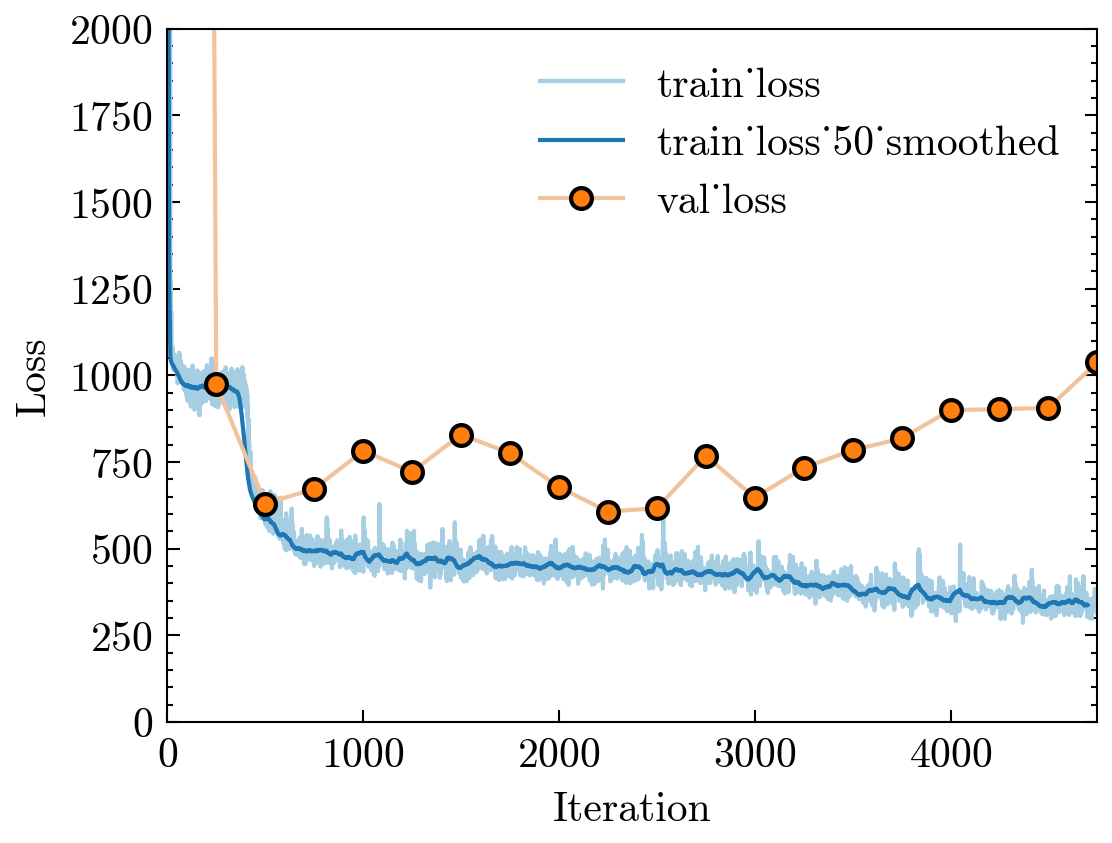

Test Loss: 971.1806168556213, use_knowledge=True, num_context=1
Test Loss: 985.3749952316284, use_knowledge=False, num_context=1
Test Loss: 696.3811085224152, use_knowledge=True, num_context=2
Test Loss: 714.9045069217682, use_knowledge=False, num_context=2
Test Loss: 598.7552511692047, use_knowledge=True, num_context=3
Test Loss: 594.2179574966431, use_knowledge=False, num_context=3
Test Loss: 561.7522120475769, use_knowledge=True, num_context=4
Test Loss: 553.4788501262665, use_knowledge=False, num_context=4
Test Loss: 519.7066385746002, use_knowledge=True, num_context=5
Test Loss: 521.0397436618805, use_knowledge=False, num_context=5
Test Loss: 483.36775183677673, use_knowledge=True, num_context=6
Test Loss: 498.3100039958954, use_knowledge=False, num_context=6
Test Loss: 492.5271542072296, use_knowledge=True, num_context=7
Test Loss: 480.51638674736023, use_knowledge=False, num_context=7
Test Loss: 478.55622386932373, use_knowledge=True, num_context=8
Test Loss: 472.9917457103729, 

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [22:14:38])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [22:14:38])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [22:14:38])
[INFO]: Saving new best val loss model at iter 1        (train.py:122 [22:14:40])


iter 1: Val. Loss (NLL): 26815.58805847168


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-87_iter1.pt'        (train.py:129 [22:14:45])
[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/np-kdropsweep-rs-87_iter250.pt        (train.py:134 [22:14:45])


iter 250: Val. Loss (NLL): 948.8269333839417


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-87_iter250.pt'        (train.py:129 [22:14:51])
[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/np-kdropsweep-rs-87_iter500.pt        (train.py:134 [22:14:51])


iter 500: Val. Loss (NLL): 612.4060559272766


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-87_iter500.pt'        (train.py:129 [22:14:56])
[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/np-kdropsweep-rs-87_iter750.pt        (train.py:134 [22:14:56])


iter 750: Val. Loss (NLL): 589.8092465400696
iter 1000: Val. Loss (NLL): 647.8900611400604
iter 1250: Val. Loss (NLL): 640.6162197589874
iter 1500: Val. Loss (NLL): 641.1574466228485
iter 1750: Val. Loss (NLL): 674.2234320640564
iter 2000: Val. Loss (NLL): 663.4342715740204
iter 2250: Val. Loss (NLL): 698.0642995834351
iter 2500: Val. Loss (NLL): 667.7660434246063
iter 2750: Val. Loss (NLL): 665.2713396549225


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-87_iter750.pt'        (train.py:129 [22:15:45])
[INFO]: Saving new best val loss model at iter 3000 to path ../exp/sweep/np-kdropsweep-rs-87_iter3000.pt        (train.py:134 [22:15:45])


iter 3000: Val. Loss (NLL): 586.0464196205139
iter 3250: Val. Loss (NLL): 597.4340591430664
iter 3500: Val. Loss (NLL): 590.2878713607788
iter 3750: Val. Loss (NLL): 621.317268371582
iter 4000: Val. Loss (NLL): 680.5742118358612
iter 4250: Val. Loss (NLL): 709.6827204227448
iter 4500: Val. Loss (NLL): 737.3710136413574
iter 4750: Val. Loss (NLL): 791.0609018802643
iter 5000: Val. Loss (NLL): 728.7292432785034
iter 5250: Val. Loss (NLL): 674.6840798854828


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [22:16:39])


iter 5500: Val. Loss (NLL): 666.239382982254


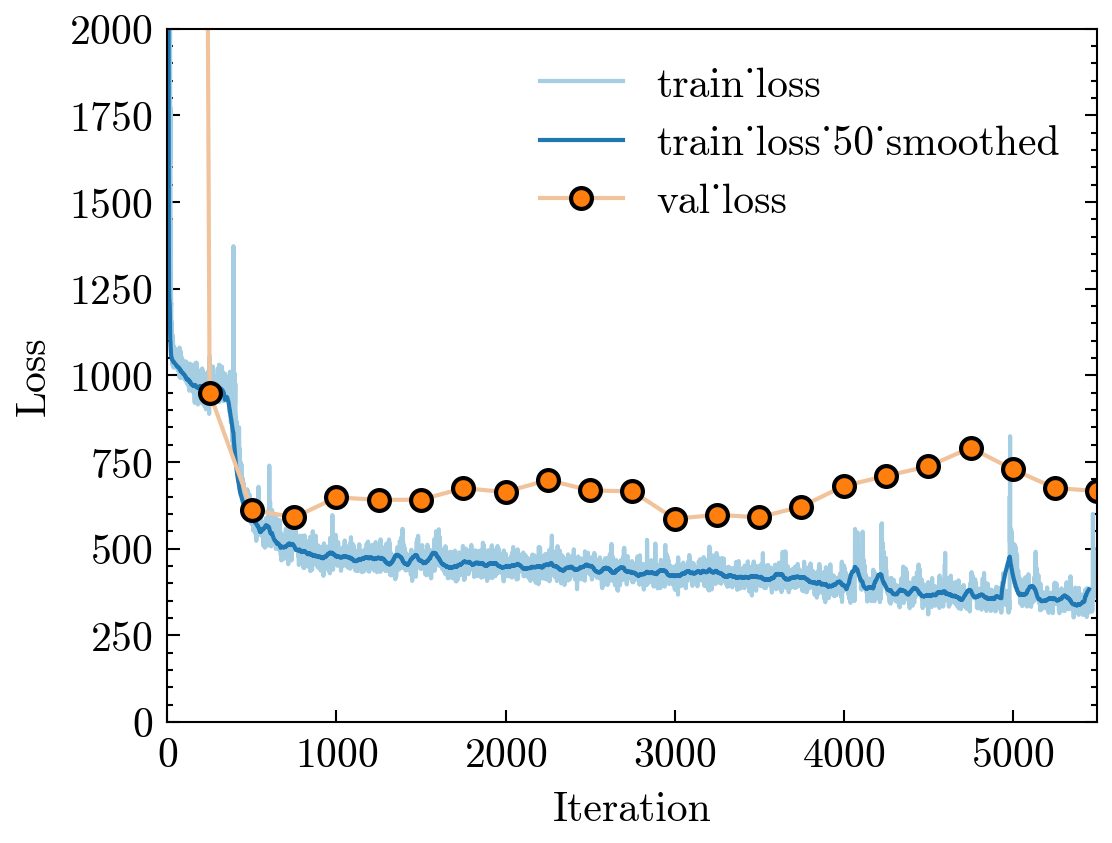

Test Loss: 1173.3773770332336, use_knowledge=True, num_context=1
Test Loss: 1212.093379020691, use_knowledge=False, num_context=1
Test Loss: 807.899409532547, use_knowledge=True, num_context=2
Test Loss: 811.0302057266235, use_knowledge=False, num_context=2
Test Loss: 658.6961874961853, use_knowledge=True, num_context=3
Test Loss: 668.1362767219543, use_knowledge=False, num_context=3
Test Loss: 599.2309877872467, use_knowledge=True, num_context=4
Test Loss: 631.7069959640503, use_knowledge=False, num_context=4
Test Loss: 553.5959303379059, use_knowledge=True, num_context=5
Test Loss: 544.2611982822418, use_knowledge=False, num_context=5
Test Loss: 525.0589871406555, use_knowledge=True, num_context=6
Test Loss: 535.5850384235382, use_knowledge=False, num_context=6
Test Loss: 506.2411992549896, use_knowledge=True, num_context=7
Test Loss: 522.0658755302429, use_knowledge=False, num_context=7
Test Loss: 509.36221718788147, use_knowledge=True, num_context=8
Test Loss: 498.2279529571533, us

In [45]:
#### NP ####
USE_KNOWLEDGE = False
logging.info(f'USE_KNOWLEDGE: {USE_KNOWLEDGE}')

np_k_test_losses = np.zeros((len(random_states), MAX_NUM_CONTEXT))
np_nok_test_losses = np.zeros((len(random_states), MAX_NUM_CONTEXT))
for idx, random_state in enumerate(random_states):
    data = TempData(data=data_df , max_num_context=MAX_NUM_CONTEXT, device=DEVICE, random_state=random_state)

    np_model = InformedNeuralProcess(
        **args,
        use_knowledge=USE_KNOWLEDGE
    ).to(DEVICE)
    np_optimiser = torch.optim.Adam(np_model.parameters(), lr=LEARNING_RATE)
    
    np_model, best_np_model_path, optimiser, train_losses, val_losses = train(model=np_model,
                                                       data=data,
                                                       loss_function=loss_function,
                                                       optimiser=np_optimiser,
                                                       device=DEVICE,
                                                       use_knowledge=USE_KNOWLEDGE,
                                                       max_iters=MAX_ITERS,
                                                       avg_loss_print_interval=AVG_LOSS_PRINT_INTERVAL,
                                                       plot_sample_interval=PLOT_SAMPLE_INTERVAL,
                                                       model_save_name=f"sweep/np-kdropsweep-rs-{random_state}",
                                                                               verbose=False)
    np_model.load_state_dict(torch.load(best_np_model_path))
    k_test_losses, nok_test_losses = k_and_nok_eval(np_model, data)
    np_k_test_losses[idx] = k_test_losses
    np_nok_test_losses[idx] = nok_test_losses

print()
print(np_k_test_losses.mean(axis=0), np_k_test_losses.std(axis=0))
print(np_nok_test_losses.mean(axis=0), np_nok_test_losses.std(axis=0))





In [47]:
np.save("np_k_test_losses3.npy", np_k_test_losses) 
np.save("np_nok_test_losses3.npy", np_nok_test_losses) 

[INFO]: USE_KNOWLEDGE: True        (502788153.py:3 [19:12:32])
[INFO]: Knowledge Dropout 0.2        (502788153.py:9 [19:12:32])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [19:12:33])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [19:12:33])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [19:12:33])
[DEBUG]: Starting new HTTPS connection (1): huggingface.co:443        (connectionpool.py:1051 [19:12:33])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [19:12:33])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [19:12:33])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to

iter 1: Val. Loss (NLL): 28037.778045654297


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [19:13:11])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-85_iter1.pt'        (train.py:129 [19:13:49])


iter 250: Val. Loss (NLL): 964.6235475540161


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-85_iter250.pt        (train.py:134 [19:13:50])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-85_iter250.pt'        (train.py:129 [19:14:28])


iter 500: Val. Loss (NLL): 628.6140179634094


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.2-rs-85_iter500.pt        (train.py:134 [19:14:29])


iter 750: Val. Loss (NLL): 668.6043515205383
iter 1000: Val. Loss (NLL): 662.3582062721252


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-85_iter500.pt'        (train.py:129 [19:16:23])


iter 1250: Val. Loss (NLL): 603.3345980644226


[INFO]: Saving new best val loss model at iter 1250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-85_iter1250.pt        (train.py:134 [19:16:24])


iter 1500: Val. Loss (NLL): 635.7883377075195


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-85_iter1250.pt'        (train.py:129 [19:17:41])


iter 1750: Val. Loss (NLL): 593.4427299499512


[INFO]: Saving new best val loss model at iter 1750 to path ../exp/sweep/inp-kdropsweep-0.2-rs-85_iter1750.pt        (train.py:134 [19:17:42])


iter 2000: Val. Loss (NLL): 652.5733866691589


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-85_iter1750.pt'        (train.py:129 [19:18:59])


iter 2250: Val. Loss (NLL): 574.9123873710632


[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-85_iter2250.pt        (train.py:134 [19:19:00])


iter 2500: Val. Loss (NLL): 591.0291094779968


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-85_iter2250.pt'        (train.py:129 [19:20:18])


iter 2750: Val. Loss (NLL): 493.3976933956146


[INFO]: Saving new best val loss model at iter 2750 to path ../exp/sweep/inp-kdropsweep-0.2-rs-85_iter2750.pt        (train.py:134 [19:20:19])


iter 3000: Val. Loss (NLL): 505.5633454322815
iter 3250: Val. Loss (NLL): 561.4340624809265
iter 3500: Val. Loss (NLL): 564.325629234314
iter 3750: Val. Loss (NLL): 534.4079027175903
iter 4000: Val. Loss (NLL): 569.5591044425964
iter 4250: Val. Loss (NLL): 554.1668210029602
iter 4500: Val. Loss (NLL): 493.73634338378906
iter 4750: Val. Loss (NLL): 539.2255892753601
iter 5000: Val. Loss (NLL): 640.0219497680664


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [19:26:46])


iter 5250: Val. Loss (NLL): 608.910758972168


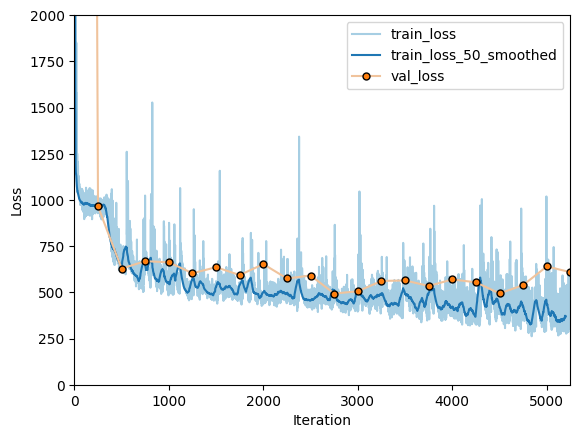

Test Loss: 597.0028676986694, use_knowledge=True, num_context=1
Test Loss: 1196.4270753860474, use_knowledge=False, num_context=1
Test Loss: 531.9229555130005, use_knowledge=True, num_context=2
Test Loss: 886.7344312667847, use_knowledge=False, num_context=2
Test Loss: 507.2847547531128, use_knowledge=True, num_context=3
Test Loss: 796.4988441467285, use_knowledge=False, num_context=3
Test Loss: 500.53274393081665, use_knowledge=True, num_context=4
Test Loss: 744.7606582641602, use_knowledge=False, num_context=4
Test Loss: 490.6792325973511, use_knowledge=True, num_context=5
Test Loss: 706.6355690956116, use_knowledge=False, num_context=5
Test Loss: 487.31153202056885, use_knowledge=True, num_context=6
Test Loss: 690.1950106620789, use_knowledge=False, num_context=6
Test Loss: 484.61914801597595, use_knowledge=True, num_context=7
Test Loss: 677.7191128730774, use_knowledge=False, num_context=7
Test Loss: 483.25051283836365, use_knowledge=True, num_context=8
Test Loss: 670.4476547241211

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [19:29:20])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [19:29:20])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [19:29:20])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [19:29:20])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [19:29:20])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [19:29:20])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [19:29:42])
[DEBUG]: Al

iter 1: Val. Loss (NLL): 25584.134368896484


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [19:29:59])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter1.pt'        (train.py:129 [19:30:39])


iter 250: Val. Loss (NLL): 997.3864984512329


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter250.pt        (train.py:134 [19:30:40])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter250.pt'        (train.py:129 [19:31:19])


iter 500: Val. Loss (NLL): 691.747917175293


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter500.pt        (train.py:134 [19:31:20])


iter 750: Val. Loss (NLL): 763.4863204956055
iter 1000: Val. Loss (NLL): 713.0742540359497


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter500.pt'        (train.py:129 [19:33:20])


iter 1250: Val. Loss (NLL): 689.4806909561157


[INFO]: Saving new best val loss model at iter 1250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter1250.pt        (train.py:134 [19:33:22])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter1250.pt'        (train.py:129 [19:34:01])


iter 1500: Val. Loss (NLL): 634.0880637168884


[INFO]: Saving new best val loss model at iter 1500 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter1500.pt        (train.py:134 [19:34:02])


iter 1750: Val. Loss (NLL): 651.1816785335541
iter 2000: Val. Loss (NLL): 729.3372273445129


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter1500.pt'        (train.py:129 [19:36:01])


iter 2250: Val. Loss (NLL): 606.8116292953491


[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter2250.pt        (train.py:134 [19:36:02])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter2250.pt'        (train.py:129 [19:36:41])


iter 2500: Val. Loss (NLL): 561.1180138587952


[INFO]: Saving new best val loss model at iter 2500 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter2500.pt        (train.py:134 [19:36:42])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter2500.pt'        (train.py:129 [19:37:22])


iter 2750: Val. Loss (NLL): 532.5657575130463


[INFO]: Saving new best val loss model at iter 2750 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter2750.pt        (train.py:134 [19:37:23])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter2750.pt'        (train.py:129 [19:38:03])


iter 3000: Val. Loss (NLL): 493.8027184009552


[INFO]: Saving new best val loss model at iter 3000 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter3000.pt        (train.py:134 [19:38:04])


iter 3250: Val. Loss (NLL): 515.6120820045471


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter3000.pt'        (train.py:129 [19:39:24])


iter 3500: Val. Loss (NLL): 490.8976194858551


[INFO]: Saving new best val loss model at iter 3500 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter3500.pt        (train.py:134 [19:39:25])


iter 3750: Val. Loss (NLL): 496.7976794242859


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter3500.pt'        (train.py:129 [19:40:44])


iter 4000: Val. Loss (NLL): 486.28279542922974


[INFO]: Saving new best val loss model at iter 4000 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter4000.pt        (train.py:134 [19:40:45])


iter 4250: Val. Loss (NLL): 501.57152819633484
iter 4500: Val. Loss (NLL): 505.8327565193176
iter 4750: Val. Loss (NLL): 539.3075470924377
iter 5000: Val. Loss (NLL): 552.2391352653503
iter 5250: Val. Loss (NLL): 533.7200427055359
iter 5500: Val. Loss (NLL): 628.424412727356
iter 5750: Val. Loss (NLL): 658.741277217865
iter 6000: Val. Loss (NLL): 699.4130511283875
iter 6250: Val. Loss (NLL): 890.2382974624634


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [19:49:20])


iter 6500: Val. Loss (NLL): 1050.34645652771


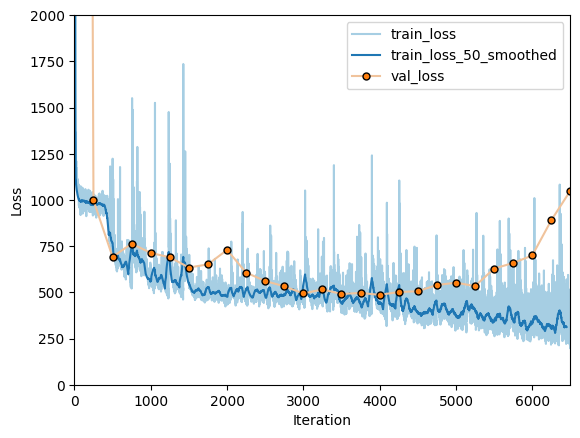

Test Loss: 531.4853599071503, use_knowledge=True, num_context=1
Test Loss: 883.1920037269592, use_knowledge=False, num_context=1
Test Loss: 496.3784921169281, use_knowledge=True, num_context=2
Test Loss: 695.268798828125, use_knowledge=False, num_context=2
Test Loss: 481.1394610404968, use_knowledge=True, num_context=3
Test Loss: 648.1073679924011, use_knowledge=False, num_context=3
Test Loss: 476.8843355178833, use_knowledge=True, num_context=4
Test Loss: 621.0388398170471, use_knowledge=False, num_context=4
Test Loss: 472.0951941013336, use_knowledge=True, num_context=5
Test Loss: 590.7366533279419, use_knowledge=False, num_context=5
Test Loss: 470.1326730251312, use_knowledge=True, num_context=6
Test Loss: 600.8277339935303, use_knowledge=False, num_context=6
Test Loss: 469.2633728981018, use_knowledge=True, num_context=7
Test Loss: 582.8833847045898, use_knowledge=False, num_context=7
Test Loss: 466.98979449272156, use_knowledge=True, num_context=8
Test Loss: 575.3416495323181, use

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [19:51:55])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [19:51:55])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [19:51:56])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [19:51:56])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [19:51:56])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [19:51:56])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [19:52:18])
[DEBUG]: Al

iter 1: Val. Loss (NLL): 26326.263717651367


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [19:52:33])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-87_iter1.pt'        (train.py:129 [19:53:11])


iter 250: Val. Loss (NLL): 954.2016215324402


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-87_iter250.pt        (train.py:134 [19:53:12])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-87_iter250.pt'        (train.py:129 [19:53:49])


iter 500: Val. Loss (NLL): 774.0541663169861


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.2-rs-87_iter500.pt        (train.py:134 [19:53:50])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-87_iter500.pt'        (train.py:129 [19:54:28])


iter 750: Val. Loss (NLL): 609.1290316581726


[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/inp-kdropsweep-0.2-rs-87_iter750.pt        (train.py:134 [19:54:29])


iter 1000: Val. Loss (NLL): 646.1921229362488
iter 1250: Val. Loss (NLL): 622.1094307899475


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-87_iter750.pt'        (train.py:129 [19:56:23])


iter 1500: Val. Loss (NLL): 535.3769545555115


[INFO]: Saving new best val loss model at iter 1500 to path ../exp/sweep/inp-kdropsweep-0.2-rs-87_iter1500.pt        (train.py:134 [19:56:24])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-87_iter1500.pt'        (train.py:129 [19:57:04])


iter 1750: Val. Loss (NLL): 528.6518187522888


[INFO]: Saving new best val loss model at iter 1750 to path ../exp/sweep/inp-kdropsweep-0.2-rs-87_iter1750.pt        (train.py:134 [19:57:05])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-87_iter1750.pt'        (train.py:129 [19:57:43])


iter 2000: Val. Loss (NLL): 515.3947825431824


[INFO]: Saving new best val loss model at iter 2000 to path ../exp/sweep/inp-kdropsweep-0.2-rs-87_iter2000.pt        (train.py:134 [19:57:44])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-87_iter2000.pt'        (train.py:129 [19:58:22])


iter 2250: Val. Loss (NLL): 507.4150676727295


[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-87_iter2250.pt        (train.py:134 [19:58:22])


iter 2500: Val. Loss (NLL): 546.1111083030701
iter 2750: Val. Loss (NLL): 521.0373871326447


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-87_iter2250.pt'        (train.py:129 [20:00:17])


iter 3000: Val. Loss (NLL): 505.3672516345978


[INFO]: Saving new best val loss model at iter 3000 to path ../exp/sweep/inp-kdropsweep-0.2-rs-87_iter3000.pt        (train.py:134 [20:00:18])


iter 3250: Val. Loss (NLL): 544.4744198322296
iter 3500: Val. Loss (NLL): 545.3386726379395
iter 3750: Val. Loss (NLL): 600.7145233154297
iter 4000: Val. Loss (NLL): 519.8213882446289
iter 4250: Val. Loss (NLL): 612.5880575180054
iter 4500: Val. Loss (NLL): 698.3846731185913
iter 4750: Val. Loss (NLL): 778.7271099090576
iter 5000: Val. Loss (NLL): 888.1213994026184
iter 5250: Val. Loss (NLL): 833.0550031661987


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [20:06:37])


iter 5500: Val. Loss (NLL): 806.7935066223145


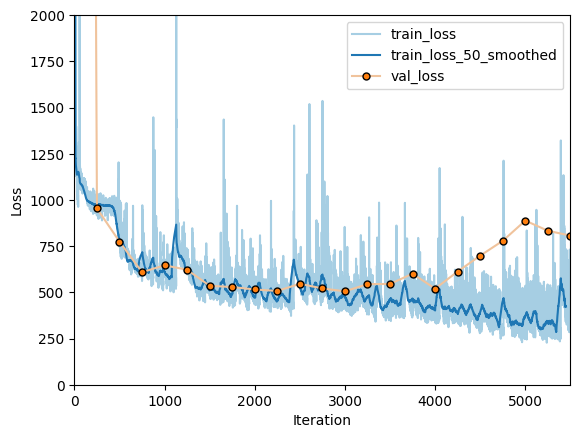

Test Loss: 559.5909600257874, use_knowledge=True, num_context=1
Test Loss: 705.9505429267883, use_knowledge=False, num_context=1
Test Loss: 530.6938135623932, use_knowledge=True, num_context=2
Test Loss: 618.1389622688293, use_knowledge=False, num_context=2
Test Loss: 521.6043334007263, use_knowledge=True, num_context=3
Test Loss: 614.5962634086609, use_knowledge=False, num_context=3
Test Loss: 519.1687455177307, use_knowledge=True, num_context=4
Test Loss: 585.7904591560364, use_knowledge=False, num_context=4
Test Loss: 516.693098783493, use_knowledge=True, num_context=5
Test Loss: 588.6011328697205, use_knowledge=False, num_context=5
Test Loss: 516.8769314289093, use_knowledge=True, num_context=6
Test Loss: 573.9292378425598, use_knowledge=False, num_context=6
Test Loss: 513.6576874256134, use_knowledge=True, num_context=7
Test Loss: 576.3016967773438, use_knowledge=False, num_context=7
Test Loss: 515.5465352535248, use_knowledge=True, num_context=8
Test Loss: 570.9438638687134, use_

[INFO]: Knowledge Dropout 0.4        (502788153.py:9 [20:09:13])


Test Loss: 563.0679087638855, use_knowledge=False, num_context=10

[562.69306254 519.66508706 503.34284973 498.86194166 493.15584183
 491.44037882 489.18006945 488.59561419 486.6622258  486.11243661] [26.83720349 16.47375338 16.75321731 17.30291916 18.29104463 19.30530075
 18.40860838 20.18030145 19.70597135 19.0298567 ]
[928.52320735 733.38073079 686.40082518 650.52998575 628.6577851
 621.65066083 612.30139812 605.57772271 597.36317333 594.26654355] [202.78559406 112.91669794  79.04399141  68.16732755  55.14551181
  49.69660078  46.33528322  45.90509187  44.27353971  42.13396417]


[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [20:09:13])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [20:09:13])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [20:09:13])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [20:09:14])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [20:09:14])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [20:09:14])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [20:09:35])
[DEBUG]: Al

iter 1: Val. Loss (NLL): 30482.353973388672


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [20:09:51])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter1.pt'        (train.py:129 [20:10:24])


iter 250: Val. Loss (NLL): 979.0727620124817


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter250.pt        (train.py:134 [20:10:25])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter250.pt'        (train.py:129 [20:10:59])


iter 500: Val. Loss (NLL): 721.4009399414062


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter500.pt        (train.py:134 [20:11:00])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter500.pt'        (train.py:129 [20:11:32])


iter 750: Val. Loss (NLL): 602.7156176567078


[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter750.pt        (train.py:134 [20:11:33])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter750.pt'        (train.py:129 [20:12:06])


iter 1000: Val. Loss (NLL): 578.2195937633514


[INFO]: Saving new best val loss model at iter 1000 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter1000.pt        (train.py:134 [20:12:08])


iter 1250: Val. Loss (NLL): 615.3490209579468
iter 1500: Val. Loss (NLL): 701.9087080955505
iter 1750: Val. Loss (NLL): 587.6531825065613


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter1000.pt'        (train.py:129 [20:14:21])


iter 2000: Val. Loss (NLL): 534.9773077964783


[INFO]: Saving new best val loss model at iter 2000 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter2000.pt        (train.py:134 [20:14:22])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter2000.pt'        (train.py:129 [20:14:56])


iter 2250: Val. Loss (NLL): 534.1872870922089


[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter2250.pt        (train.py:134 [20:14:57])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter2250.pt'        (train.py:129 [20:15:29])


iter 2500: Val. Loss (NLL): 523.1412272453308


[INFO]: Saving new best val loss model at iter 2500 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter2500.pt        (train.py:134 [20:15:30])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter2500.pt'        (train.py:129 [20:16:05])


iter 2750: Val. Loss (NLL): 520.7748575210571


[INFO]: Saving new best val loss model at iter 2750 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter2750.pt        (train.py:134 [20:16:06])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter2750.pt'        (train.py:129 [20:16:39])


iter 3000: Val. Loss (NLL): 519.6068885326385


[INFO]: Saving new best val loss model at iter 3000 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter3000.pt        (train.py:134 [20:16:40])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter3000.pt'        (train.py:129 [20:17:13])


iter 3250: Val. Loss (NLL): 504.68994975090027


[INFO]: Saving new best val loss model at iter 3250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter3250.pt        (train.py:134 [20:17:14])


iter 3500: Val. Loss (NLL): 512.6203935146332
iter 3750: Val. Loss (NLL): 505.2024245262146


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter3250.pt'        (train.py:129 [20:18:54])


iter 4000: Val. Loss (NLL): 466.0236611366272


[INFO]: Saving new best val loss model at iter 4000 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter4000.pt        (train.py:134 [20:18:55])


iter 4250: Val. Loss (NLL): 489.2879002094269
iter 4500: Val. Loss (NLL): 474.7967908382416
iter 4750: Val. Loss (NLL): 468.77805852890015
iter 5000: Val. Loss (NLL): 473.53641867637634
iter 5250: Val. Loss (NLL): 504.03279852867126
iter 5500: Val. Loss (NLL): 478.43444776535034
iter 5750: Val. Loss (NLL): 509.3624486923218
iter 6000: Val. Loss (NLL): 521.3290090560913
iter 6250: Val. Loss (NLL): 484.9512333869934


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [20:24:29])


iter 6500: Val. Loss (NLL): 607.2207221984863


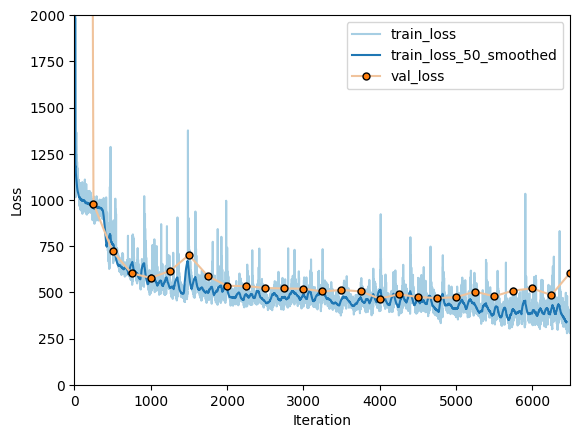

Test Loss: 600.4707551002502, use_knowledge=True, num_context=1
Test Loss: 839.5036253929138, use_knowledge=False, num_context=1
Test Loss: 538.164379119873, use_knowledge=True, num_context=2
Test Loss: 722.7268283367157, use_knowledge=False, num_context=2
Test Loss: 498.3817615509033, use_knowledge=True, num_context=3
Test Loss: 659.4727504253387, use_knowledge=False, num_context=3
Test Loss: 488.09182715415955, use_knowledge=True, num_context=4
Test Loss: 574.8960099220276, use_knowledge=False, num_context=4
Test Loss: 480.88483715057373, use_knowledge=True, num_context=5
Test Loss: 571.9853892326355, use_knowledge=False, num_context=5
Test Loss: 474.93980407714844, use_knowledge=True, num_context=6
Test Loss: 540.612735748291, use_knowledge=False, num_context=6
Test Loss: 471.38922786712646, use_knowledge=True, num_context=7
Test Loss: 530.9222726821899, use_knowledge=False, num_context=7
Test Loss: 466.65475940704346, use_knowledge=True, num_context=8
Test Loss: 513.6238555908203, 

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [20:27:01])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [20:27:01])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [20:27:01])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [20:27:01])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [20:27:01])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [20:27:01])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [20:27:23])
[DEBUG]: Al

iter 1: Val. Loss (NLL): 28994.387664794922


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [20:27:39])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter1.pt'        (train.py:129 [20:28:12])


iter 250: Val. Loss (NLL): 977.2531218528748


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter250.pt        (train.py:134 [20:28:14])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter250.pt'        (train.py:129 [20:28:48])


iter 500: Val. Loss (NLL): 779.9358730316162


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter500.pt        (train.py:134 [20:28:49])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter500.pt'        (train.py:129 [20:29:22])


iter 750: Val. Loss (NLL): 685.5639629364014


[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter750.pt        (train.py:134 [20:29:23])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter750.pt'        (train.py:129 [20:29:56])


iter 1000: Val. Loss (NLL): 659.2624678611755


[INFO]: Saving new best val loss model at iter 1000 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter1000.pt        (train.py:134 [20:29:57])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter1000.pt'        (train.py:129 [20:30:31])


iter 1250: Val. Loss (NLL): 647.6935877799988


[INFO]: Saving new best val loss model at iter 1250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter1250.pt        (train.py:134 [20:30:32])


iter 1500: Val. Loss (NLL): 665.6626334190369


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter1250.pt'        (train.py:129 [20:31:41])


iter 1750: Val. Loss (NLL): 623.2715222835541


[INFO]: Saving new best val loss model at iter 1750 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter1750.pt        (train.py:134 [20:31:41])


iter 2000: Val. Loss (NLL): 648.3815884590149


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter1750.pt'        (train.py:129 [20:32:49])


iter 2250: Val. Loss (NLL): 588.3896288871765


[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter2250.pt        (train.py:134 [20:32:50])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter2250.pt'        (train.py:129 [20:33:25])


iter 2500: Val. Loss (NLL): 553.1348152160645


[INFO]: Saving new best val loss model at iter 2500 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter2500.pt        (train.py:134 [20:33:26])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter2500.pt'        (train.py:129 [20:34:00])


iter 2750: Val. Loss (NLL): 498.6726348400116


[INFO]: Saving new best val loss model at iter 2750 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter2750.pt        (train.py:134 [20:34:01])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter2750.pt'        (train.py:129 [20:34:35])


iter 3000: Val. Loss (NLL): 481.9547543525696


[INFO]: Saving new best val loss model at iter 3000 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter3000.pt        (train.py:134 [20:34:35])


iter 3250: Val. Loss (NLL): 566.9092621803284
iter 3500: Val. Loss (NLL): 497.28973364830017
iter 3750: Val. Loss (NLL): 512.6426436901093
iter 4000: Val. Loss (NLL): 624.031581401825
iter 4250: Val. Loss (NLL): 500.52500224113464
iter 4500: Val. Loss (NLL): 527.6276807785034
iter 4750: Val. Loss (NLL): 492.53983211517334
iter 5000: Val. Loss (NLL): 532.5074231624603
iter 5250: Val. Loss (NLL): 521.8602383136749


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [20:40:14])


iter 5500: Val. Loss (NLL): 499.5866587162018


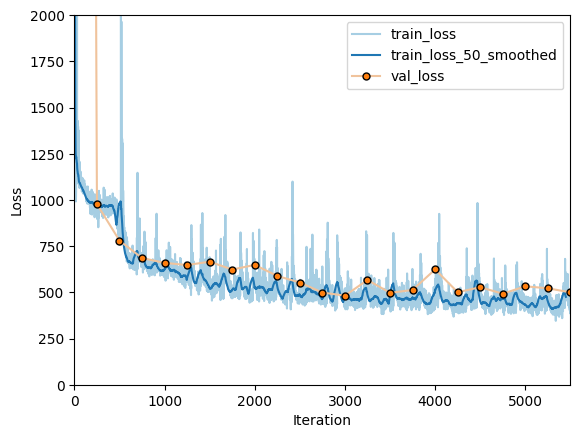

Test Loss: 589.3980340957642, use_knowledge=True, num_context=1
Test Loss: 1148.4246768951416, use_knowledge=False, num_context=1
Test Loss: 510.35494327545166, use_knowledge=True, num_context=2
Test Loss: 858.0927720069885, use_knowledge=False, num_context=2
Test Loss: 469.44398164749146, use_knowledge=True, num_context=3
Test Loss: 677.4457325935364, use_knowledge=False, num_context=3
Test Loss: 460.95633935928345, use_knowledge=True, num_context=4
Test Loss: 606.7074251174927, use_knowledge=False, num_context=4
Test Loss: 455.78572177886963, use_knowledge=True, num_context=5
Test Loss: 544.4528751373291, use_knowledge=False, num_context=5
Test Loss: 452.87495255470276, use_knowledge=True, num_context=6
Test Loss: 518.2773449420929, use_knowledge=False, num_context=6
Test Loss: 450.0813729763031, use_knowledge=True, num_context=7
Test Loss: 512.6055178642273, use_knowledge=False, num_context=7
Test Loss: 448.37831926345825, use_knowledge=True, num_context=8
Test Loss: 497.40835762023

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [20:42:46])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [20:42:46])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [20:42:46])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [20:42:46])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [20:42:46])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [20:42:46])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [20:43:08])
[DEBUG]: Al

iter 1: Val. Loss (NLL): 24237.331832885742


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [20:43:23])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter1.pt'        (train.py:129 [20:43:54])


iter 250: Val. Loss (NLL): 947.4859709739685


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter250.pt        (train.py:134 [20:43:55])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter250.pt'        (train.py:129 [20:44:28])


iter 500: Val. Loss (NLL): 632.4012246131897


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter500.pt        (train.py:134 [20:44:29])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter500.pt'        (train.py:129 [20:45:00])


iter 750: Val. Loss (NLL): 610.0877733230591


[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter750.pt        (train.py:134 [20:45:01])


iter 1000: Val. Loss (NLL): 646.5369625091553


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter750.pt'        (train.py:129 [20:46:05])


iter 1250: Val. Loss (NLL): 596.7315475940704


[INFO]: Saving new best val loss model at iter 1250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter1250.pt        (train.py:134 [20:46:06])


iter 1500: Val. Loss (NLL): 649.2025673389435
iter 1750: Val. Loss (NLL): 614.5717270374298


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter1250.pt'        (train.py:129 [20:47:44])


iter 2000: Val. Loss (NLL): 592.8444068431854


[INFO]: Saving new best val loss model at iter 2000 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter2000.pt        (train.py:134 [20:47:45])


iter 2250: Val. Loss (NLL): 662.3559648990631


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter2000.pt'        (train.py:129 [20:48:49])


iter 2500: Val. Loss (NLL): 570.288281917572


[INFO]: Saving new best val loss model at iter 2500 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter2500.pt        (train.py:134 [20:48:50])


iter 2750: Val. Loss (NLL): 595.4294676780701
iter 3000: Val. Loss (NLL): 613.1795637607574
iter 3250: Val. Loss (NLL): 572.3654472827911
iter 3500: Val. Loss (NLL): 591.219648361206


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter2500.pt'        (train.py:129 [20:51:31])


iter 3750: Val. Loss (NLL): 493.12974095344543


[INFO]: Saving new best val loss model at iter 3750 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter3750.pt        (train.py:134 [20:51:32])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter3750.pt'        (train.py:129 [20:52:06])


iter 4000: Val. Loss (NLL): 481.27678060531616


[INFO]: Saving new best val loss model at iter 4000 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter4000.pt        (train.py:134 [20:52:07])


iter 4250: Val. Loss (NLL): 485.50613832473755
iter 4500: Val. Loss (NLL): 486.0921297073364
iter 4750: Val. Loss (NLL): 507.5978195667267
iter 5000: Val. Loss (NLL): 483.5978922843933
iter 5250: Val. Loss (NLL): 504.8169023990631
iter 5500: Val. Loss (NLL): 510.4050440788269
iter 5750: Val. Loss (NLL): 531.2854764461517
iter 6000: Val. Loss (NLL): 560.8468041419983
iter 6250: Val. Loss (NLL): 536.5288593769073


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [20:57:40])


iter 6500: Val. Loss (NLL): 525.1147553920746


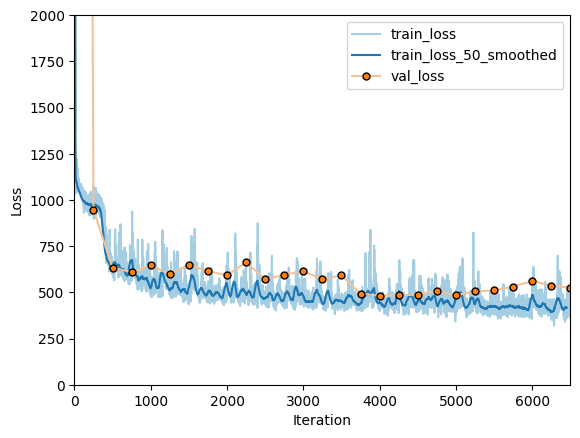

Test Loss: 595.3423018455505, use_knowledge=True, num_context=1
Test Loss: 1030.4870057106018, use_knowledge=False, num_context=1
Test Loss: 538.1326117515564, use_knowledge=True, num_context=2
Test Loss: 836.2100555896759, use_knowledge=False, num_context=2
Test Loss: 509.4300391674042, use_knowledge=True, num_context=3
Test Loss: 697.8710262775421, use_knowledge=False, num_context=3
Test Loss: 496.6815507411957, use_knowledge=True, num_context=4
Test Loss: 629.3663923740387, use_knowledge=False, num_context=4
Test Loss: 493.8654713630676, use_knowledge=True, num_context=5
Test Loss: 576.5174150466919, use_knowledge=False, num_context=5
Test Loss: 484.8592355251312, use_knowledge=True, num_context=6
Test Loss: 573.8374938964844, use_knowledge=False, num_context=6
Test Loss: 478.3435072898865, use_knowledge=True, num_context=7
Test Loss: 541.0904700756073, use_knowledge=False, num_context=7
Test Loss: 474.5772931575775, use_knowledge=True, num_context=8
Test Loss: 515.8221142292023, us

[INFO]: Knowledge Dropout 0.6        (502788153.py:9 [21:00:15])


Test Loss: 502.2609119415283, use_knowledge=False, num_context=10

[595.07036368 528.88397805 492.41859412 481.90990575 476.84534343
 470.89133072 466.60470271 463.20345728 462.58274961 460.49116675] [ 4.52450737 13.10201256 16.86002616 15.22574128 15.80622165 13.36765229
 12.02374927 10.97057194 10.50754774  9.54597409]
[1006.138436    805.67655198  678.26316977  603.65660914  564.31855981
  544.24252486  528.20608687  508.95144248  500.81584342  495.4890159 ] [127.28627486  59.33074419  15.68668331  22.34183296  14.16848345
  22.82709012  11.78647175   8.21138199  15.24755655  10.06147792]


[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [21:00:15])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [21:00:15])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [21:00:16])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [21:00:16])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [21:00:16])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [21:00:16])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [21:00:38])
[DEBUG]: Al

iter 1: Val. Loss (NLL): 30310.236236572266


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [21:00:53])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter1.pt'        (train.py:129 [21:01:21])


iter 250: Val. Loss (NLL): 972.3087668418884


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter250.pt        (train.py:134 [21:01:22])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter250.pt'        (train.py:129 [21:01:50])


iter 500: Val. Loss (NLL): 957.5700297355652


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter500.pt        (train.py:134 [21:01:50])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter500.pt'        (train.py:129 [21:02:18])


iter 750: Val. Loss (NLL): 785.7867078781128


[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter750.pt        (train.py:134 [21:02:19])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter750.pt'        (train.py:129 [21:02:48])


iter 1000: Val. Loss (NLL): 648.7755408287048


[INFO]: Saving new best val loss model at iter 1000 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter1000.pt        (train.py:134 [21:02:48])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter1000.pt'        (train.py:129 [21:03:17])


iter 1250: Val. Loss (NLL): 621.7037672996521


[INFO]: Saving new best val loss model at iter 1250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter1250.pt        (train.py:134 [21:03:18])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter1250.pt'        (train.py:129 [21:03:45])


iter 1500: Val. Loss (NLL): 576.4021425247192


[INFO]: Saving new best val loss model at iter 1500 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter1500.pt        (train.py:134 [21:03:46])


iter 1750: Val. Loss (NLL): 591.2217326164246


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter1500.pt'        (train.py:129 [21:04:42])


iter 2000: Val. Loss (NLL): 545.3646032810211


[INFO]: Saving new best val loss model at iter 2000 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter2000.pt        (train.py:134 [21:04:43])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter2000.pt'        (train.py:129 [21:05:12])


iter 2250: Val. Loss (NLL): 534.9831898212433


[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter2250.pt        (train.py:134 [21:05:13])


iter 2500: Val. Loss (NLL): 581.9406809806824


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter2250.pt'        (train.py:129 [21:06:08])


iter 2750: Val. Loss (NLL): 495.50860929489136


[INFO]: Saving new best val loss model at iter 2750 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter2750.pt        (train.py:134 [21:06:09])


iter 3000: Val. Loss (NLL): 502.73758006095886
iter 3250: Val. Loss (NLL): 532.8443737030029
iter 3500: Val. Loss (NLL): 498.2989151477814


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter2750.pt'        (train.py:129 [21:07:59])


iter 3750: Val. Loss (NLL): 467.82035660743713


[INFO]: Saving new best val loss model at iter 3750 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter3750.pt        (train.py:134 [21:08:00])


iter 4000: Val. Loss (NLL): 484.5895116329193


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter3750.pt'        (train.py:129 [21:08:57])


iter 4250: Val. Loss (NLL): 467.2093551158905


[INFO]: Saving new best val loss model at iter 4250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter4250.pt        (train.py:134 [21:08:58])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter4250.pt'        (train.py:129 [21:09:27])


iter 4500: Val. Loss (NLL): 461.6784052848816


[INFO]: Saving new best val loss model at iter 4500 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter4500.pt        (train.py:134 [21:09:28])


iter 4750: Val. Loss (NLL): 470.33172631263733
iter 5000: Val. Loss (NLL): 471.25309228897095
iter 5250: Val. Loss (NLL): 490.06067395210266
iter 5500: Val. Loss (NLL): 474.81088733673096
iter 5750: Val. Loss (NLL): 496.5857331752777
iter 6000: Val. Loss (NLL): 487.5111827850342
iter 6250: Val. Loss (NLL): 479.6859517097473
iter 6500: Val. Loss (NLL): 532.2372894287109
iter 6750: Val. Loss (NLL): 495.2813096046448


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [21:14:09])


iter 7000: Val. Loss (NLL): 482.6397683620453


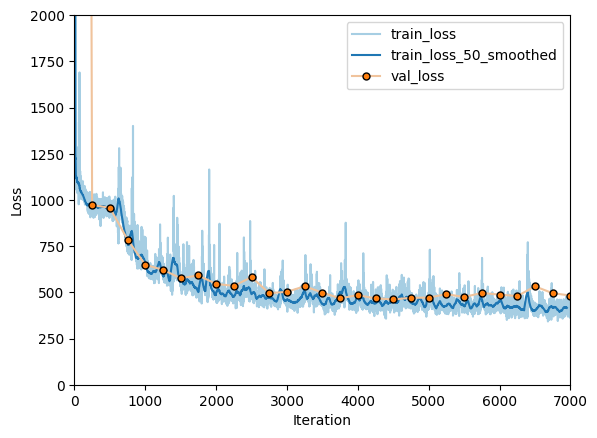

Test Loss: 593.8130433559418, use_knowledge=True, num_context=1
Test Loss: 896.8664679527283, use_knowledge=False, num_context=1
Test Loss: 521.8455104827881, use_knowledge=True, num_context=2
Test Loss: 704.2382037639618, use_knowledge=False, num_context=2
Test Loss: 493.383887052536, use_knowledge=True, num_context=3
Test Loss: 605.0294284820557, use_knowledge=False, num_context=3
Test Loss: 486.74636721611023, use_knowledge=True, num_context=4
Test Loss: 574.2528600692749, use_knowledge=False, num_context=4
Test Loss: 470.8671817779541, use_knowledge=True, num_context=5
Test Loss: 541.4306819438934, use_knowledge=False, num_context=5
Test Loss: 466.62847208976746, use_knowledge=True, num_context=6
Test Loss: 520.319638967514, use_knowledge=False, num_context=6
Test Loss: 464.2121641635895, use_knowledge=True, num_context=7
Test Loss: 502.1696705818176, use_knowledge=False, num_context=7
Test Loss: 458.9958121776581, use_knowledge=True, num_context=8
Test Loss: 499.63582468032837, us

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [21:16:43])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [21:16:43])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [21:16:43])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [21:16:43])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [21:16:43])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [21:16:43])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [21:17:05])
[DEBUG]: Al

iter 1: Val. Loss (NLL): 29239.12889099121


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [21:17:22])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter1.pt'        (train.py:129 [21:17:51])


iter 250: Val. Loss (NLL): 989.0656037330627


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter250.pt        (train.py:134 [21:17:52])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter250.pt'        (train.py:129 [21:18:21])


iter 500: Val. Loss (NLL): 965.000855922699


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter500.pt        (train.py:134 [21:18:22])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter500.pt'        (train.py:129 [21:18:52])


iter 750: Val. Loss (NLL): 664.5187635421753


[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter750.pt        (train.py:134 [21:18:53])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter750.pt'        (train.py:129 [21:19:22])


iter 1000: Val. Loss (NLL): 654.0172591209412


[INFO]: Saving new best val loss model at iter 1000 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter1000.pt        (train.py:134 [21:19:23])


iter 1250: Val. Loss (NLL): 700.5902080535889
iter 1500: Val. Loss (NLL): 656.6350793838501


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter1000.pt'        (train.py:129 [21:20:49])


iter 1750: Val. Loss (NLL): 646.8730273246765


[INFO]: Saving new best val loss model at iter 1750 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter1750.pt        (train.py:134 [21:20:50])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter1750.pt'        (train.py:129 [21:21:19])


iter 2000: Val. Loss (NLL): 587.4346597194672


[INFO]: Saving new best val loss model at iter 2000 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter2000.pt        (train.py:134 [21:21:20])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter2000.pt'        (train.py:129 [21:21:50])


iter 2250: Val. Loss (NLL): 540.0895552635193


[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter2250.pt        (train.py:134 [21:21:51])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter2250.pt'        (train.py:129 [21:22:20])


iter 2500: Val. Loss (NLL): 527.7992918491364


[INFO]: Saving new best val loss model at iter 2500 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter2500.pt        (train.py:134 [21:22:21])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter2500.pt'        (train.py:129 [21:22:49])


iter 2750: Val. Loss (NLL): 511.70326566696167


[INFO]: Saving new best val loss model at iter 2750 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter2750.pt        (train.py:134 [21:22:50])


iter 3000: Val. Loss (NLL): 512.7576887607574
iter 3250: Val. Loss (NLL): 540.9106967449188
iter 3500: Val. Loss (NLL): 545.16570353508
iter 3750: Val. Loss (NLL): 519.9703888893127


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter2750.pt'        (train.py:129 [21:25:12])


iter 4000: Val. Loss (NLL): 493.99404859542847


[INFO]: Saving new best val loss model at iter 4000 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter4000.pt        (train.py:134 [21:25:13])


iter 4250: Val. Loss (NLL): 530.2722747325897
iter 4500: Val. Loss (NLL): 513.6560959815979
iter 4750: Val. Loss (NLL): 524.6557037830353
iter 5000: Val. Loss (NLL): 535.6754879951477
iter 5250: Val. Loss (NLL): 562.2063257694244
iter 5500: Val. Loss (NLL): 508.9247033596039
iter 5750: Val. Loss (NLL): 514.6010665893555
iter 6000: Val. Loss (NLL): 495.5147120952606
iter 6250: Val. Loss (NLL): 526.3953771591187


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [21:30:03])


iter 6500: Val. Loss (NLL): 518.7695128917694


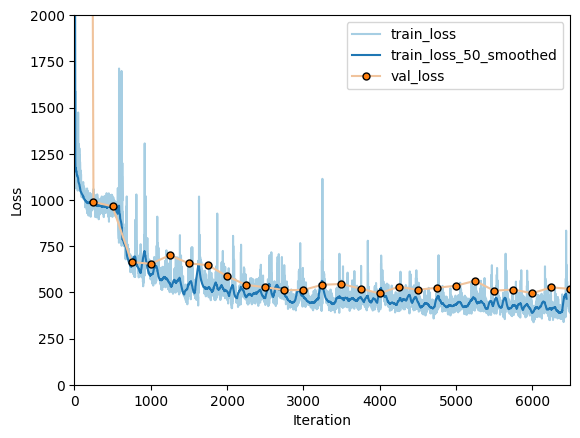

Test Loss: 552.4232592582703, use_knowledge=True, num_context=1
Test Loss: 1136.229398727417, use_knowledge=False, num_context=1
Test Loss: 489.59056425094604, use_knowledge=True, num_context=2
Test Loss: 772.3672273159027, use_knowledge=False, num_context=2
Test Loss: 475.4874041080475, use_knowledge=True, num_context=3
Test Loss: 637.3332889080048, use_knowledge=False, num_context=3
Test Loss: 461.4122076034546, use_knowledge=True, num_context=4
Test Loss: 622.496737241745, use_knowledge=False, num_context=4
Test Loss: 460.15446496009827, use_knowledge=True, num_context=5
Test Loss: 546.8825011253357, use_knowledge=False, num_context=5
Test Loss: 456.25512075424194, use_knowledge=True, num_context=6
Test Loss: 535.5518333911896, use_knowledge=False, num_context=6
Test Loss: 455.2681369781494, use_knowledge=True, num_context=7
Test Loss: 511.2601182460785, use_knowledge=False, num_context=7
Test Loss: 452.73420000076294, use_knowledge=True, num_context=8
Test Loss: 490.1829388141632, 

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [21:32:37])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [21:32:37])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [21:32:37])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [21:32:37])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [21:32:37])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [21:32:37])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [21:32:59])
[DEBUG]: Al

iter 1: Val. Loss (NLL): 22440.067810058594


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [21:33:14])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-87_iter1.pt'        (train.py:129 [21:33:41])


iter 250: Val. Loss (NLL): 955.3333330154419


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-87_iter250.pt        (train.py:134 [21:33:42])


iter 500: Val. Loss (NLL): 1137.5359058380127


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-87_iter250.pt'        (train.py:129 [21:34:35])


iter 750: Val. Loss (NLL): 646.516405582428


[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/inp-kdropsweep-0.6-rs-87_iter750.pt        (train.py:134 [21:34:36])


iter 1000: Val. Loss (NLL): 1150.9208416938782


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-87_iter750.pt'        (train.py:129 [21:35:31])


iter 1250: Val. Loss (NLL): 610.1017079353333


[INFO]: Saving new best val loss model at iter 1250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-87_iter1250.pt        (train.py:134 [21:35:32])


iter 1500: Val. Loss (NLL): 625.9096522331238
iter 1750: Val. Loss (NLL): 653.7141637802124
iter 2000: Val. Loss (NLL): 702.58527135849
iter 2250: Val. Loss (NLL): 679.9229900836945
iter 2500: Val. Loss (NLL): 713.1310031414032
iter 2750: Val. Loss (NLL): 649.4608390331268
iter 3000: Val. Loss (NLL): 616.6842501163483
iter 3250: Val. Loss (NLL): 714.734662771225
iter 3500: Val. Loss (NLL): 640.1315364837646


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [21:40:11])


iter 3750: Val. Loss (NLL): 619.9572265148163


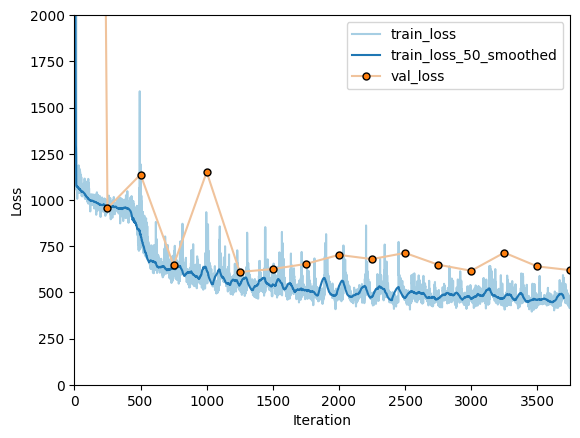

Test Loss: 779.1768226623535, use_knowledge=True, num_context=1
Test Loss: 892.2826013565063, use_knowledge=False, num_context=1
Test Loss: 689.6803760528564, use_knowledge=True, num_context=2
Test Loss: 705.5930466651917, use_knowledge=False, num_context=2
Test Loss: 657.286871433258, use_knowledge=True, num_context=3
Test Loss: 650.1818261146545, use_knowledge=False, num_context=3
Test Loss: 612.4270935058594, use_knowledge=True, num_context=4
Test Loss: 630.7819626331329, use_knowledge=False, num_context=4
Test Loss: 610.2740345001221, use_knowledge=True, num_context=5
Test Loss: 605.8700218200684, use_knowledge=False, num_context=5
Test Loss: 598.4790291786194, use_knowledge=True, num_context=6
Test Loss: 598.569607257843, use_knowledge=False, num_context=6
Test Loss: 583.2751941680908, use_knowledge=True, num_context=7
Test Loss: 583.055163860321, use_knowledge=False, num_context=7
Test Loss: 578.153892993927, use_knowledge=True, num_context=8
Test Loss: 575.3983244895935, use_kno

In [4]:
#### INP ####
USE_KNOWLEDGE = True
logging.info(f'USE_KNOWLEDGE: {USE_KNOWLEDGE}')

inp_k_test_losses = np.zeros((3, len(random_states), MAX_NUM_CONTEXT))
inp_nok_test_losses = np.zeros((3, len(random_states), MAX_NUM_CONTEXT))

for kidx, knowledge_dropout in enumerate([0.2, 0.4, 0.6]):
    logging.info(f"Knowledge Dropout {knowledge_dropout}")
    
    for ridx, random_state in enumerate(random_states):
        data = TempData(data=data_df, max_num_context=MAX_NUM_CONTEXT, device=DEVICE, random_state=random_state)
        
        inp_model = InformedNeuralProcess(
            **args,
            knowledge_dropout=knowledge_dropout,
            use_knowledge=USE_KNOWLEDGE
        ).to(DEVICE)
        inp_optimiser = torch.optim.Adam(inp_model.parameters(), lr=LEARNING_RATE)
        
        inp_model, best_inp_model_path, optimiser, train_losses, val_losses = train(model=inp_model,
                                                           data=data,
                                                           loss_function=loss_function,
                                                           optimiser=inp_optimiser,
                                                           device=DEVICE,
                                                           use_knowledge=USE_KNOWLEDGE,
                                                           max_iters=MAX_ITERS,
                                                           avg_loss_print_interval=AVG_LOSS_PRINT_INTERVAL,
                                                           plot_sample_interval=PLOT_SAMPLE_INTERVAL,
                                                           model_save_name=f"sweep/inp-kdropsweep-{knowledge_dropout}-rs-{random_state}",
                                                                                   verbose=False)
        inp_model.load_state_dict(torch.load(best_inp_model_path))
        k_test_losses, nok_test_losses = k_and_nok_eval(inp_model, data)
        inp_k_test_losses[kidx, ridx] = k_test_losses
        inp_nok_test_losses[kidx, ridx] = nok_test_losses
        
        print()
    print(inp_k_test_losses[kidx].mean(axis=0), inp_k_test_losses[kidx].std(axis=0))
    print(inp_nok_test_losses[kidx].mean(axis=0), inp_nok_test_losses[kidx].std(axis=0))

In [5]:
np.save("inp_k_test_losses-true.npy", inp_k_test_losses) 
np.save("inp_nok_test_losses-true.npy", inp_nok_test_losses) 

In [5]:
inp_k_test_losses_03 = np.load("../notebooks/inp_k_test_losses.npy")
inp_nok_test_losses_03 = np.load("../notebooks/inp_nok_test_losses.npy")


In [3]:
n = 3
np_k_test_losses = np.load(f"../notebooks/np_k_test_losses{n}.npy")
np_nok_test_losses = np.load(f"../notebooks/np_nok_test_losses{n}.npy")

inp_k_test_losses = np.load(f"../notebooks/inp_k_test_losses-true.npy")
inp_nok_test_losses = np.load(f"../notebooks/inp_nok_test_losses-true.npy")

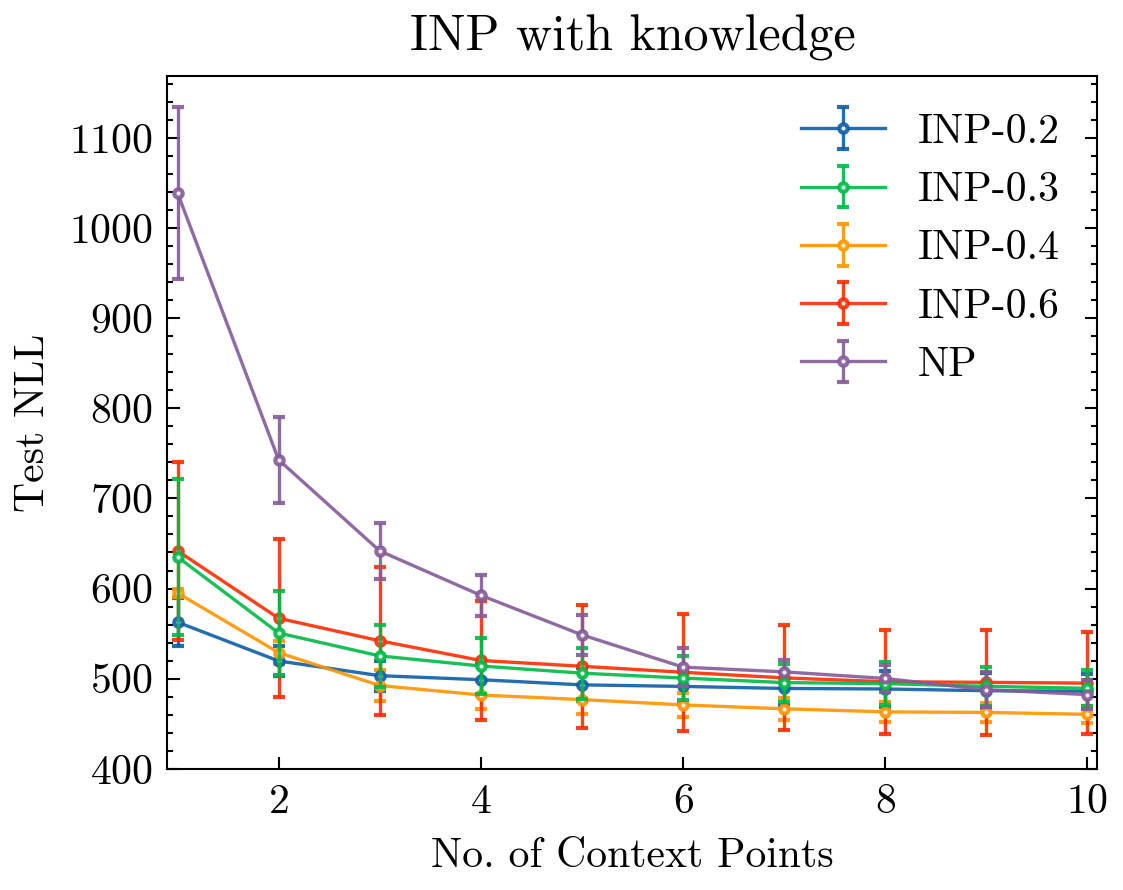

In [18]:
plt.style.use('../figures/mplstyles/thesis.mplstyle')

# Plot the data
# plt.figure(figsize=(10, 6))
num_context_points = range(1, 11)
# plt.plot(num_context_points, inp_test_losses_array.mean(axis=0), label='INP', marker='o', markersize=3)
# plt.plot(num_context_points, np_test_losses_array.mean(axis=0), label='NP', marker='x', markersize=3)
for i, k_dropout in enumerate([0.2, 0.4, 0.6]):
    if k_dropout == 0.4:
        plt.errorbar(num_context_points, 
             inp_k_test_losses_03[1].mean(axis=0), 
             yerr=inp_k_test_losses_03[1].std(axis=0), 
             capsize=1.5,  marker='o', markersize=2,  linestyle='-', linewidth=0.8,
              alpha=0.9, mfc='white',zorder=12, label="INP-0.3")
    
    plt.errorbar(num_context_points, 
                 inp_k_test_losses[i].mean(axis=0), 
                 yerr=inp_k_test_losses[i].std(axis=0), 
                 capsize=1.5,marker='o', linestyle='-', markersize=2, linewidth=0.8,
                 alpha=0.9, mfc='white',zorder=11, label=f"INP-{k_dropout}")

plt.errorbar(num_context_points, 
             np_k_test_losses.mean(axis=0), 
             yerr=np_k_test_losses.std(axis=0), 
             capsize=1.5,  marker='o', markersize=2,  linestyle='-', linewidth=0.8,
              alpha=0.9, mfc='white',zorder=12, label="NP")

plt.xlabel('No. of Context Points')
plt.ylabel('Test NLL')
plt.title("INP with knowledge")
plt.legend()
plt.xlim(0.9, 10.1)
plt.ylim(400,)
# plt.grid()
plt.savefig(f'../figures/knowledge-inp_vs_np_context_points-true.png', dpi=600)
plt.show()


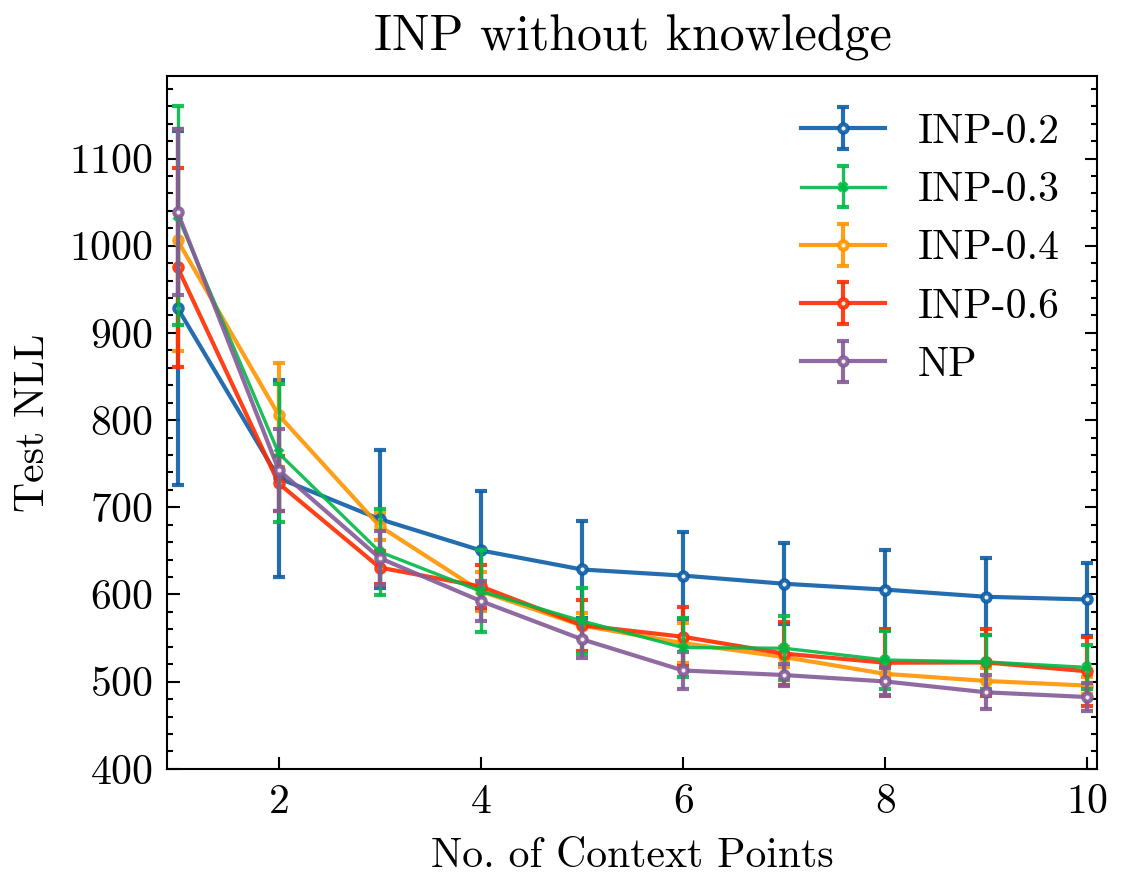

In [19]:
# Plot the data
# plt.figure(figsize=(10, 6))
num_context_points = range(1, 11)
# plt.plot(num_context_points, inp_test_losses_array.mean(axis=0), label='INP', marker='o', markersize=3)
# plt.plot(num_context_points, np_test_losses_array.mean(axis=0), label='NP', marker='x', markersize=3)
for i, k_dropout in enumerate([0.2, 0.4, 0.6]):
    if k_dropout == 0.4:
        plt.errorbar(num_context_points, 
             inp_nok_test_losses_03[1].mean(axis=0), 
             yerr=inp_nok_test_losses_03[1].std(axis=0), 
             capsize=1.5,  marker='x', markersize=2,  linestyle='-', linewidth=0.8,
              alpha=0.9, mfc='white',zorder=12, label="INP-0.3")

    plt.errorbar(num_context_points, 
                 inp_nok_test_losses[i].mean(axis=0), 
                 yerr=inp_nok_test_losses[i].std(axis=0), 
                 capsize=1.5,marker='o', markersize=2, alpha=0.9, mfc='white',zorder=11, label=f"INP-{k_dropout}")


plt.errorbar(num_context_points, 
             np_k_test_losses.mean(axis=0), 
             yerr=np_k_test_losses.std(axis=0), 
             capsize=1.5,  marker='o', markersize=2,  alpha=0.9, mfc='white',zorder=12, label="NP")

plt.xlabel('No. of Context Points')
plt.ylabel('Test NLL')
plt.title("INP without knowledge")
plt.legend()
np_k_test_losses
plt.xlim(0.9, 10.1)
plt.ylim(400,)
plt.savefig(f'../figures/noknowledge-inp_vs_np_context_points-true.png', dpi=600)
plt.show()
